In [1]:
from datasets import load_dataset

emotions = load_dataset('emotion')

print(f"column names: {emotions.column_names}")
print(f"fetures: {emotions['train'].features}")

emotions.set_format('pandas')

df_train = emotions['train'][:]
df_train.head()

C:\Users\patry\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|████████████████████████████████████████████| 2000/2000 [00:00<00:00, 441761.44 examples/s]

column names: {'train': ['text', 'label'], 'validation': ['text', 'label'], 'test': ['text', 'label']}
fetures: {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [2]:
def label_int2str(label):
    return emotions['train'].features['label'].int2str(label)

df_train['label_name'] = df_train['label'].apply(label_int2str)
df_train.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


<Axes: title={'center': 'word_per_tweet'}, xlabel='label_name'>

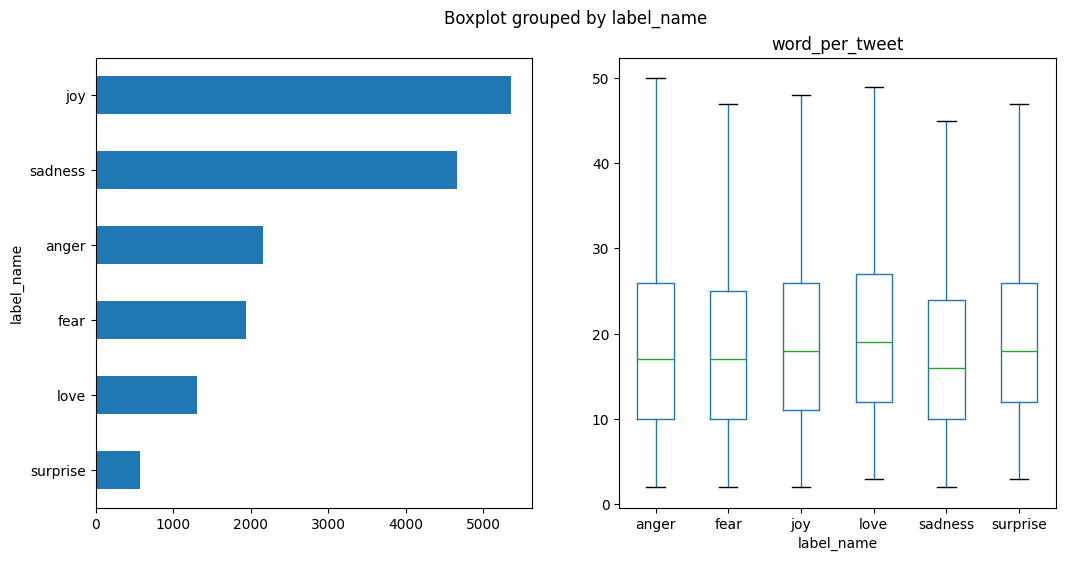

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

df_train['word_per_tweet'] = df_train['text'].str.split().apply(len)

df_train['label_name'].value_counts(ascending=True).plot.barh(ax=axes[0])

df_train.boxplot('word_per_tweet', by='label_name', grid=False, showfliers=False, ax=axes[1])

In [4]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [5]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

emotions.reset_format()

emotions_encoded = emotions.map(tokenize, batch_size=None, batched=True)

Map: 100%|███████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 12278.32 examples/s]


In [6]:
from transformers import AutoModel
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModel.from_pretrained(model_ckpt).to(device)

In [7]:
emotions_encoded['train'].column_names

['text', 'label', 'input_ids', 'attention_mask']

In [8]:
emotions_encoded.set_format('torch', columns=['label', 'input_ids', 'attention_mask'])

def extride_last_hidden_state(batch):
    inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

    with torch.inference_mode():
        hidden_state = model(**inputs).last_hidden_state

    return {'hidden_state': hidden_state[:, 0].cpu().numpy()}

hidden_state = emotions_encoded.map(extride_last_hidden_state, batched=True)

Map: 100%|█████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 518.91 examples/s]


In [9]:
import numpy as np

# create train test and validation data
X_train = np.array(hidden_state['train']['hidden_state'])
X_val = np.array(hidden_state['validation']['hidden_state'])
y_train = np.array(hidden_state['train']['label'])
y_val = np.array(hidden_state['validation']['label'])

In [10]:
from umap import UMAP
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

X_scale = MinMaxScaler().fit_transform(X_train)

mapper = UMAP(n_components=2, metric='cosine').fit(X_scale)

df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'y'])
df_emb['label'] = y_train


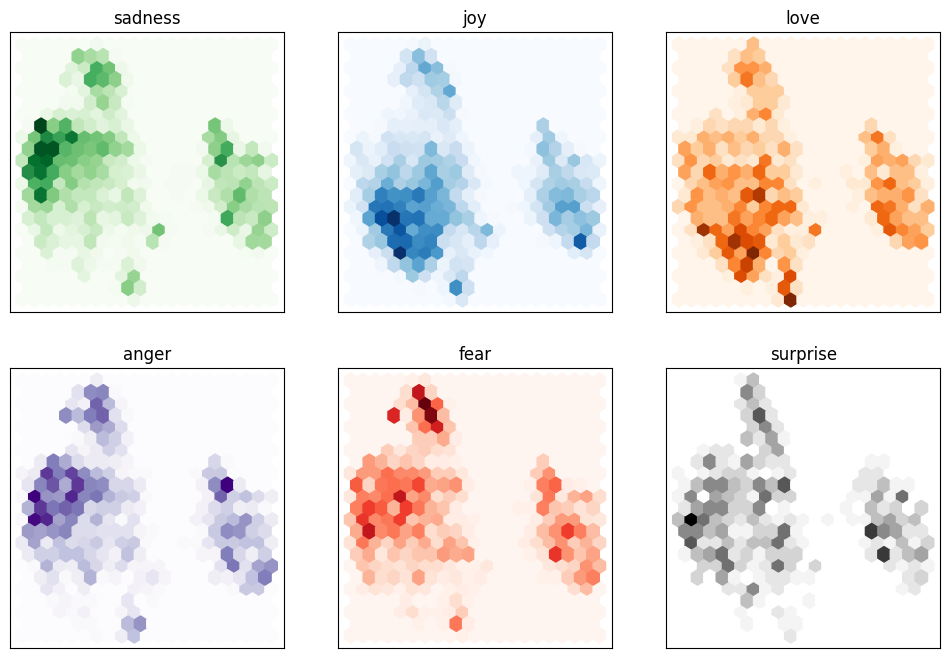

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes = axes.flatten()

labels = emotions['train'].features['label'].names

cmaps = ['Greens', 'Blues', 'Oranges', 'Purples', 'Reds', 'Greys']

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_sbp_eb = df_emb.query(f"label == {i}")
    
    axes[i].hexbin(df_sbp_eb['X'], df_sbp_eb['y'], cmap=cmap, gridsize=20)
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Parameters for grid search
params = {
    'pca__n_components': [5, 10, 15],  # Number of components for PCA
    'svc__C': [0.1, 1, 10],  # Regularization parameter
    'svc__gamma': [1e-07, 1e-08, 1e-09],  # Kernel coefficient
    'svc__kernel': ['rbf', 'linear']  # Kernel type
}

# Define PCA and SVC
pca = PCA()
svc = SVC()

# Create a pipeline
pipeline = Pipeline([
    ('pca', pca),
    ('svc', svc)
])

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, params, n_jobs=-1, cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_}")

# Extract the best estimator
best_model = grid_search.best_estimator_

Best parameters: {'pca__n_components': 15, 'svc__C': 1, 'svc__gamma': 1e-07, 'svc__kernel': 'linear'}
Best accuracy: 0.489375


In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cofusion_matrix(y_true, y_pred, labels):
    fig, axes = plt.subplots(figsize=(6, 6))

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    disp.plot(colorbar=False, cmap='Blues', values_format=".2f", ax=axes)

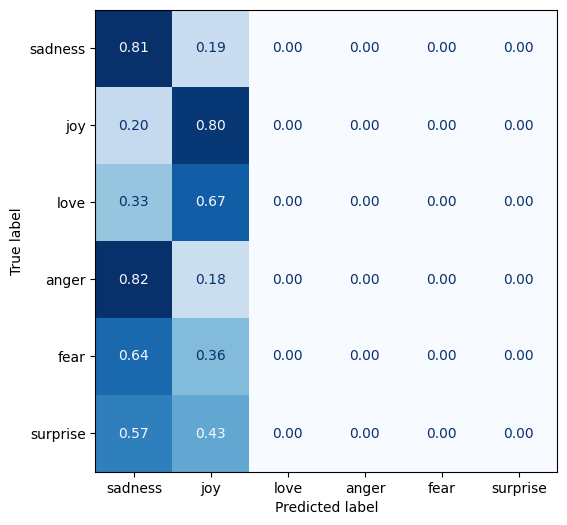

In [14]:
y_pred = best_model.predict(X_val)

plot_cofusion_matrix(y_val, y_pred, labels)

In [15]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

# Parameters for grid search
params_lr = {
    'C': [0.1, 1, 10], 
    'solver': ['liblinear', 'saga']
}

params_sgd = {
    'alpha': [1e-4, 1e-3, 1e-2],
    'penalty': ['l2', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.1, 1]
}

# Logistic Regression GridSearchCV
lr_clf = LogisticRegression(max_iter=4000)
grid_search_lr = GridSearchCV(lr_clf, params_lr, cv=5, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

print(f"Best params for Logistic Regression: {grid_search_lr.best_params_}")
print(f"Best score for Logistic Regression: {grid_search_lr.best_score_}")

# SGD Classifier GridSearchCV
sgd_clf = SGDClassifier(loss='log_loss', fit_intercept=True, max_iter=4000)
grid_search_sgd = GridSearchCV(sgd_clf, params_sgd, cv=5, n_jobs=-1)
grid_search_sgd.fit(X_train, y_train)

print(f"Best params for SGD Classifier: {grid_search_sgd.best_params_}")
print(f"Best score for SGD Classifier: {grid_search_sgd.best_score_}")

# Best models
best_lr_clf = grid_search_lr.best_estimator_
best_sgd_clf = grid_search_sgd.best_estimator_

# Predictions on the validation set
y_pred_lr = best_lr_clf.predict(X_val)
y_pred_sgd = best_sgd_clf.predict(X_val)

# Plot confusion matrix for Logistic Regression
plot_cofusion_matrix(y_val, y_pred_lr, labels)

# Plot confusion matrix for SGD Classifier
plot_cofusion_matrix(y_val, y_pred_sgd, labels)

Best params for Logistic Regression: {'C': 1, 'solver': 'saga'}
Best score for Logistic Regression: 0.6361875


KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))



In [ ]:
from transformers import AutoModelForSequenceClassification

num_class = len(labels)

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_class).to(device)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f"{model_ckpt} - finetuned - emotion"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy='epoch',
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level='error'
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded['train'],
    eval_dataset=emotions_encoded['validation'],
    tokenizer=tokenizer
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.685500,0.279265,0.915500,0.915023
2,0.231800,0.215196,0.921500,0.921346


TrainOutput(global_step=500, training_loss=0.4586704559326172, metrics={'train_runtime': 241.7323, 'train_samples_per_second': 132.378, 'train_steps_per_second': 2.068, 'total_flos': 720342861696000.0, 'train_loss': 0.4586704559326172, 'epoch': 2.0})

In [ ]:
# Predictions 
preds_output = trainer.predict(emotions_encoded['validation'])
preds_output.metrics

{'test_loss': 0.21519619226455688,
 'test_accuracy': 0.9215,
 'test_f1': 0.9213459864511971,
 'test_runtime': 4.2956,
 'test_samples_per_second': 465.588,
 'test_steps_per_second': 7.449}

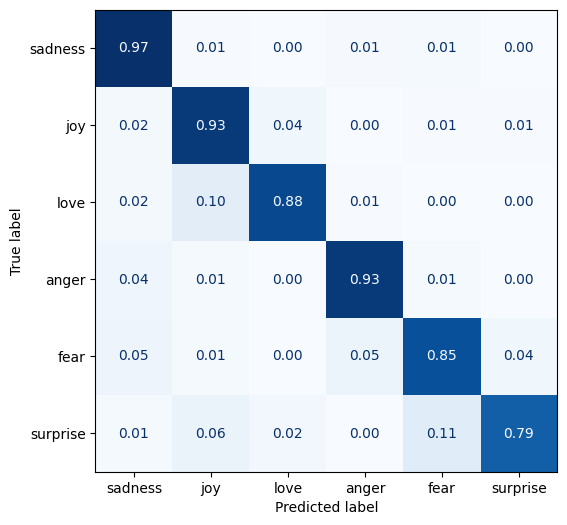

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=-1)
plot_cofusion_matrix(y_pred=y_preds, y_true=y_val, labels=labels)

### Error analisys 

In [ ]:
from torch.nn.functional import cross_entropy

def loss_calculation(batch):
    # Place all inputs tensors on the same device
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

    with torch.inference_mode():
        output = model(**inputs)
        pred_labels = torch.argmax(output.logits, axis=-1)

        loss = cross_entropy(output.logits, batch['label'].to(device), reduction='none')

        return {'loss': loss.cpu().numpy(),
                'predictions': pred_labels.cpu().numpy()}

# Convert data to torch tensor
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Calculate loss value
emotions_encoded['validation'] = emotions_encoded['validation'].map(loss_calculation, batched=True, batch_size=16)


TypeError: Values in `DatasetDict` should be of type `Dataset` but got type '<class 'datasets.dataset_dict.DatasetDict'>'

In [ ]:
emotions_encoded.reset_format()

TypeError: Values in `DatasetDict` should be of type `Dataset` but got type '<class 'datasets.dataset_dict.DatasetDict'>'

In [ ]:
# Convert data to pandas format
emotions_encoded.reset_format()
emotions_encoded.set_format('pandas')
df_test = emotions_encoded['validation'][:]['text', 'label', 'predictions', 'loss']

df_test['label'] = df_test['label'].apply(label_int2str)
df_test['predictions'] = df_test['predictions'].apply(label_int2str)

TypeError: Values in `DatasetDict` should be of type `Dataset` but got type '<class 'datasets.dataset_dict.DatasetDict'>'